In [1]:
#Getting our trained resnet model
from torchvision import models
from torchvision.models import ResNet50_Weights

model = models.resnet50(weights = ResNet50_Weights.DEFAULT)

Loading and Preprocessing our Images and storing them in array.\
Make sure that the images are in the same directory as this file.

In [2]:
#Loading our images and preprocessing them
from PIL import Image
import numpy as np
import torch
from torch.autograd import Variable

image_paths = ['./i1.jpg','./i2.jpg','./i3.jpg','./i4.jpg',
               './i5.jpg']

image_path = './i2.jpg'
original_images = []
images_as_variables = []

#Preprocessing our images
for i in range(5):
    image_path = image_paths[i]
    original_image = Image.open(image_path).convert('RGB')
    original_images.append(original_image)
    
    mean = [0.485,0.456,0.406]
    std = [0.229,0.224,0.225]

    #Resize the image
    original_image = original_image.resize((224,224))

    im_as_arr = np.float32(original_image)
    im_as_arr = im_as_arr.transpose(2,0,1) #Pytorch follows a diffrent order

    #Normalizing Values
    for channel,_ in enumerate(im_as_arr):
        im_as_arr[channel]/=255
        im_as_arr[channel]-=mean[channel]
        im_as_arr[channel]/=std[channel]

    im_as_ten = torch.from_numpy(im_as_arr).float()
    im_as_ten.unsqueeze_(0)

    im_as_var = Variable(im_as_ten, requires_grad = True)
    images_as_variables.append(im_as_var)


Writing a Vanilla Backprop class using hooks to get the gradients for the intermediate nodes.

In [3]:
class VanillaBackprop():
    def __init__(self,model):
        self.model = model
        self.gradient = None

        #putting the model in evaluation mode
        self.model.eval()

        #Hook the first layer to get the gradient
        self.hook_layers()
    
    #Defining our hook layers
    def hook_layers(self):
        def hook_function(module,grad_in,grad_out):
            self.gradients = grad_in[0]

        #Register hook to the first layer
        first_layer = list(self.model.children())[0]
        first_layer.register_backward_hook(hook_function)
    
    def generate_gradient(self,input_image):
        #Forward Pass
        model_output = self.model(input_image)
        target_class = torch.argmax(model_output,dim = 1)

        #Zero Grads
        self.model.zero_grad()

        #Since we need only backprop with the highest prediced
        #neuron we can use one hot encoding i.e highest predicted
        #neuron gets 1 and remaining 0 making them ineffective
        one_hot_output = torch.FloatTensor(1,model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1

        #Backward Pass using our one-hot-output
        model_output.backward(gradient = one_hot_output)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr


Showing our results for vanilla backprop we need to process the output again to be able to display in\
in matplotlib.

/home/vasisht/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


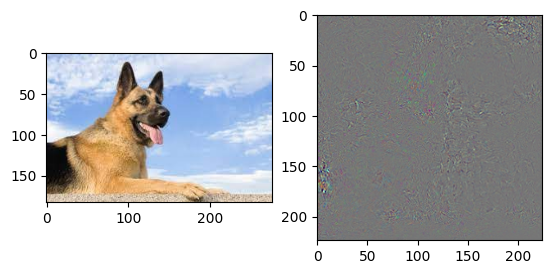

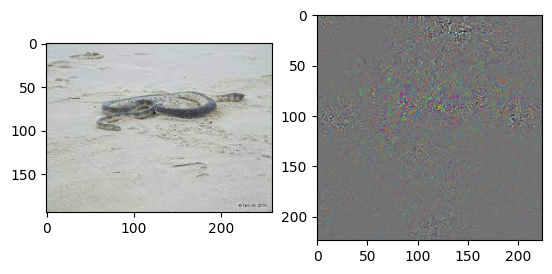

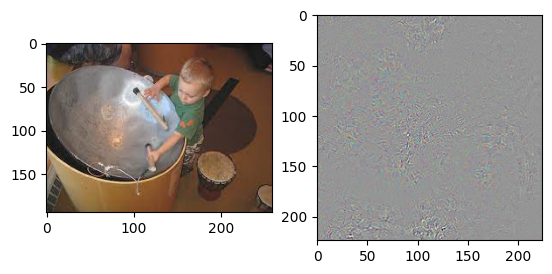

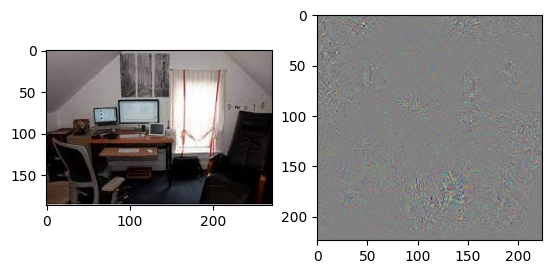

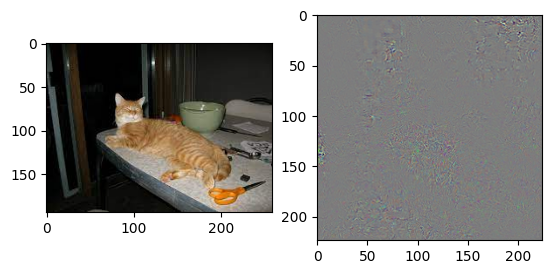

In [4]:
import matplotlib.pyplot as plt

VBP = VanillaBackprop(model)
for i in range(5):
    vanilla_grads = VBP.generate_gradient(images_as_variables[i])

    #Normalizing our gradients so we can plot as image
    vanilla_grads = vanilla_grads - vanilla_grads.min()#Makes them positive
    vanilla_grads /= vanilla_grads.max()#Changes all the values to b/w 0 and 1
    vanilla_grads = vanilla_grads.transpose(1,2,0)#pyplot has a diffrent order for images
    if np.max(vanilla_grads) <= 1:
        vanilla_grads = (vanilla_grads*255).astype(np.uint8)
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(original_images[i])
    axarr[1].imshow(vanilla_grads)

Question2: Writing a class for Guided Back prop again using hooks to get intermediate node gradients\
We need to make sure that we discard negative gradients.

In [5]:
from torch.nn import ReLU

class GuidedBackprop():
    def __init__(self,model):
        self.model = model
        self.gradients = None

        #Put model in eval mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()
    
    #Defining our hook layer functions.
    def hook_layers(self):
        def hook_function(module,grad_in,grad_out):
            self.gradients = grad_in[0]

        #Registering hook to te first layer
        first_layer = list(self.model.children())[0]
        first_layer.register_backward_hook(hook_function)
    
    #defining relu hook function
    def update_relus(self):

        def relu_hook_function(module,grad_in,grad_out):
            #Discards Negative gradient values
            if isinstance(module, ReLU):
                return (torch.clamp(grad_in[0],min = 0.0),)
        for module in self.model.modules():
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_hook_function)
    
    def generate_gradient(self,input_image):
        #Forward Pass
        model_output = self.model(input_image)
        target_class = torch.argmax(model_output,dim = 1)

        #Zero Grads
        self.model.zero_grad()

        #Since we need only backprop with the highest prediced
        #neuron we can use one hot encoding i.e highest predicted
        #neuron gets 1 and remaining 0 making them ineffective
        one_hot_output = torch.FloatTensor(1,model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1

        #Backward Pass using our one-hot-output
        model_output.backward(gradient = one_hot_output)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr   


Showing the images for our guided back prop results, once again we need to process the output\
so that we can display our results using matplotlib.

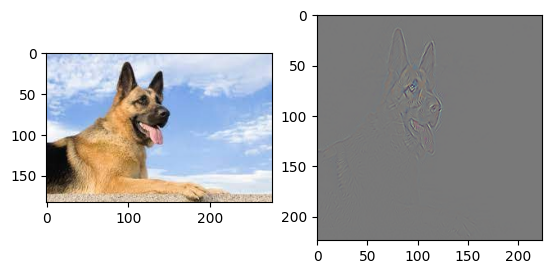

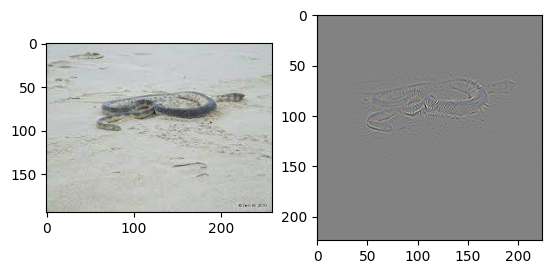

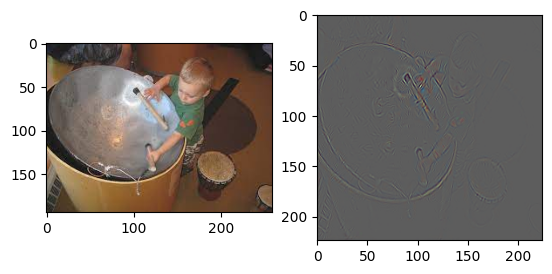

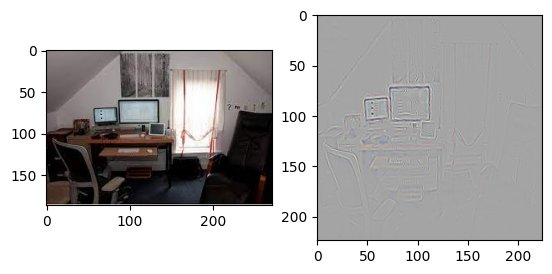

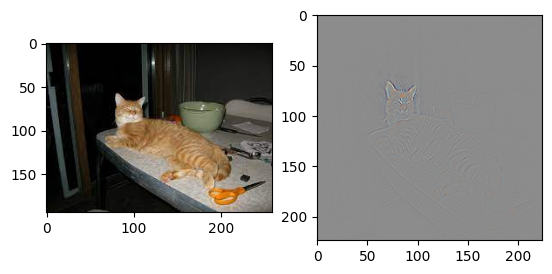

In [6]:
GBP = GuidedBackprop(model)
for i in range(5):
    guided_grads = GBP.generate_gradient(images_as_variables[i])
    guided_grads = guided_grads -guided_grads.min()
    guided_grads /= guided_grads.max()
    guided_grads = guided_grads.transpose(1,2,0)
# print(vanilla_grads.shape)
    if np.max(guided_grads) <= 1:
        guided_grads = (guided_grads*255).astype(np.uint8)
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(original_images[i])
    axarr[1].imshow(guided_grads)

Question3: In Class Activation Map we need to change the last layer of a network to GAP but resnet50 already\
has a GAP layer so we need not change it and can directly catch the last layer once again using hooks and get our activation map.

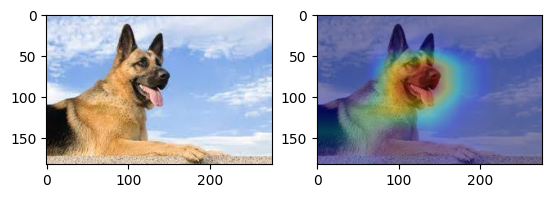

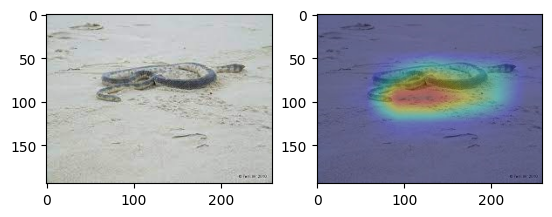

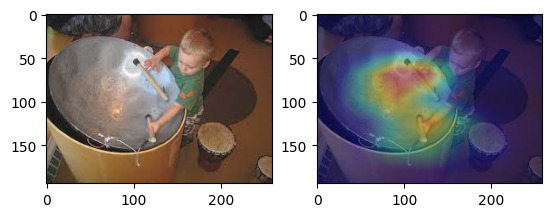

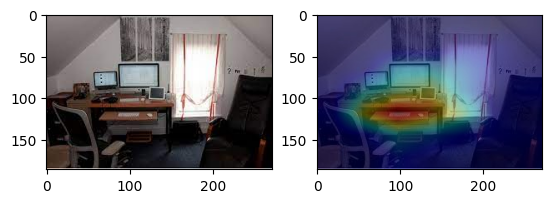

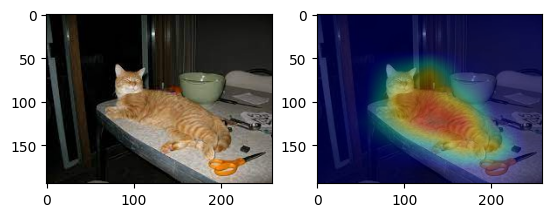

In [7]:
import io
import torch.nn.functional as F
import cv2
import os
output_paths = ['./CAM1.jpg','./CAM2.jpg','./CAM3.jpg','./CAM4.jpg','./CAM5.jpg']

for i in range(5):

    model2 = model
    model2.eval()#setting our model to eval mode

    #Hook features.
    features_blobs = []
    def hook_feature(module, input,output):
        features_blobs.append(output.data.cpu().numpy())

    #Layer 4 is the final convulution layer in resnet50 and we
    #catch that so that we can get CAM
    model2._modules.get('layer4').register_forward_hook(hook_feature)

    params = list(model2.parameters())
    weight_softmax = np.squeeze(params[-2].data.numpy())

    #Return Cam function which returns the Class Activation Map
    def return_cam(feature_conv, weight_softmax, class_idx):
        size_upsample = (256,256)
        bz , nc , h , w = feature_conv.shape
        output_cam = []

        for idx in class_idx:
            cam = weight_softmax[idx].dot(feature_conv.reshape((nc,h*w)))
            cam = cam.reshape(h,w)
            cam = cam - np.min(cam)
            cam_img = cam / np.max(cam)
            cam_img = np.uint8(255*cam_img)
            output_cam.append(cv2.resize(cam_img,size_upsample))
            return output_cam


    output = model2(images_as_variables[i])
    prob_x = F.softmax(output, dim =1 ).data.squeeze()#Applying softmax so that we can get probabilites
    probs,idx = prob_x.sort(0,True)#Sorting those probabilites.
    probs = probs.numpy()#Converting to numpy arrays
    idx = idx.numpy()

    #Plotting our CAMs
    CAMs = return_cam(features_blobs[0],weight_softmax,[idx[0]])
    img = cv2.imread(image_paths[i])#So that we can resize our heatmap later
    height, width, _ = img.shape
    heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)#Applying heatmap
    result = heatmap * 0.3 + img * 0.5
    cv2.imwrite(output_paths[i], result)
    heatmap_image = Image.open(output_paths[i])
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(original_images[i])
    axarr[1].imshow(heatmap_image)
    os.remove(output_paths[i])#Removing unnecessary images.
    

In [8]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from IPython import display

Defining our function and our gradient calculator.

In [9]:
def function(x,y):
    return 10 * x ** 2 + y ** 2

def gradient(x,y):
    list = []
    list.append(20*x)
    list.append(2*y)
    return list

Question1 : Vanilla SGD Function definiton.

In [10]:
def vanilla_sgd(nita, iterations, x, y):
    X = []
    Y = []
    Z = []

    X.append(x)
    Y.append(y)
    Z.append(function(x,y))

    for i in range(iterations):
        gradient_point = gradient(x,y)
        x = x - nita * gradient_point[0]
        y = y - nita * gradient_point[1]
        X.append(x)
        Y.append(y)
        Z.append(function(x,y))
    return X,Y,Z

Question2: SGD + momentum function definition

In [11]:
def sgd_momentum(rho, nita, iterations, x, y):
    X = []
    Y = []
    Z = []
    v = [0,0]

    X.append(x)
    Y.append(y)
    Z.append(function(x,y))

    for i in range(iterations):
        gradient_point = gradient(x,y)

        v[0] = rho * v[0] + gradient_point[0]
        v[1] = rho * v[1] + gradient_point[1]
        x = x - nita*v[0]
        y = y - nita * v[1]
        X.append(x)
        Y.append(y)
        Z.append(function(x,y))

    return X,Y,Z

Question3 : Nestrov Momentum Function Definition

In [12]:
def nestrov_momentum(rho, nita, iterations,x,y):
    X = []
    Y = []
    Z = []
    X.append(x)
    Y.append(y)
    Z.append(function(x,y))

    change = [0,0]

    for i in range(iterations):
        proj_x = x + rho * change[0]
        proj_y = y + rho * change[1]
        gradient_point = gradient(proj_x, proj_y)

        change[0] = rho * change[0] - nita * gradient_point[0]
        change[1] = rho * change[1] - nita * gradient_point[1]

        x = x + change[0]
        y = y + change[1]
        X.append(x)
        Y.append(y)
        Z.append(function(x,y))
    
    return X,Y,Z

Question4 : Ada Grad Function Definition.

In [13]:
def ada_grad(nita, epsilon, iterations, x, y):
    X =[]
    Y = []
    Z = []
    X.append(x)
    Y.append(y)
    Z.append(function(x,y))

    grad_sq = [0.0,0.0] 
    
    for i in range(iterations):
        gradient_point = gradient(x,y)
        grad_sq[0] = grad_sq[0] + gradient_point[0] * gradient_point[0]
        grad_sq[1] = grad_sq[1] + gradient_point[1] * gradient_point[1]

        x = x - nita * gradient_point[0]/(np.sqrt(grad_sq[0]) + epsilon)
        y = y - nita * gradient_point[1]/(np.sqrt(grad_sq[1]) + epsilon)

        X.append(x)
        Y.append(y)
        Z.append(function(x,y))

    return X,Y,Z

Question5 : RMS Prop function defintion.

In [14]:
def rms_prop(rho, nita, epsilon, iterations, x, y):
    X = []
    Y = []
    Z = []
    X.append(x)
    Y.append(y)
    Z.append(function(x,y))

    grad_sq = [0.0, 0.0]

    for i in range(iterations):
        gradient_point = gradient(x,y)
        grad_sq[0] = rho * grad_sq[0] + (1-rho) * gradient_point[0] * gradient_point[0]
        grad_sq[1] = rho * grad_sq[1] + (1-rho) * gradient_point[1] * gradient_point[1]

        x = x - nita * gradient_point[0]/(np.sqrt(grad_sq[0]) + epsilon)
        y = y - nita * gradient_point[1]/(np.sqrt(grad_sq[1]) + epsilon)

        X.append(x)
        Y.append(y)
        Z.append(function(x,y))
    
    return X,Y,Z

Final printing our GIF/Mp4

In [15]:
x = 20.0
y = 20.0

#SGD
X_sgd,Y_sgd,Z_sgd = vanilla_sgd(0.01, 100, x, y)

#SGD + Momentum
X_momentum, Y_momentum , Z_momentum = sgd_momentum(0.9,0.001,100,x,y)

#Nestrov Momentum
X_nestrov,Y_nestrov, Z_nestrov = nestrov_momentum(0.99,0.0001,100,x,y)

#Ada Grad
X_ada,Y_ada,Z_ada = ada_grad(0.99999,0.0001,100,x,y)

#RMS Prop
X_rms,Y_rms,Z_rms = rms_prop(0.9,0.1,0.001,100,x,y)

#Creating arrays for our contour plot
feature_x = np.linspace(-50.0, 50.0, 100)
feature_y = np.linspace(-50.0, 50.0, 100)
[X, Y] = np.meshgrid(feature_x, feature_y)
Z = 10* X ** 2 + Y ** 2

fig, ax = plt.subplots()

# generate some data
x = np.linspace(0, 10, 100)
y = np.sin(x)

# creating the update function for funcanimation.
def update(i):
  ax.contourf(X, Y, Z)
  
  
  plt.scatter(X_sgd[:i],Y_sgd[:i],color = 'blue',label = 'Vanilla')
  plt.scatter(X_momentum[:i],Y_momentum[:i],color = 'orange',label = 'Momentum')
  plt.scatter(X_nestrov[:i],Y_nestrov[:i],color = 'green', label = 'Nestrov')
  plt.scatter(X_ada[:i],Y_ada[:i],color = 'red', label = 'Adagrad')
  plt.scatter(X_rms[:i],Y_rms[:i],color='purple', label = 'RMS_prop')
  plt.xlim([-50.0,50.0])
  plt.ylim([-50.0,50.0])
  plt.title("Various Update rules")


#Data for legend
data=np.array([[X_sgd,Y_sgd,Z_sgd],[X_momentum,Y_momentum,Z_momentum],[X_nestrov,Y_nestrov,Z_nestrov],[X_ada,Y_ada,Z_ada],[X_rms,Y_rms,Z_rms]])
colors=['black','red','blue','green','yellow']
plots=['vanilla sgd','sgd with momentum','nesterov momentum','Ada Grad','RMS prop']
point = [ax.plot(d[0, 0:1], d[1, 0:1], d[2, 0:1],colors[i],label=plots[i])[0]  for i,d in enumerate(data)]

ax.legend(point,plots,loc=3)

# create the animation object
anim = FuncAnimation(fig, update, frames=100, interval=50)



# show the plot
video = anim.to_html5_video()
  
# embedding for the video
html = display.HTML(video)
 
# draw the animation
display.display(html)
plt.close()

